In [79]:
from scipy.io import wavfile
from scipy import signal
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import numpy as np
from scipy import constants

import pandas as pd

In [80]:
def biquad(arr, a0, a1, a2, b0, b1, b2):
    x_prev1 = 0 #x sub n-1
    x_prev2 = 0 #x sub n-2
    
    y_prev1 = 0 #y prev n-1
    y_prev2 = 0 #y sub n-2
    
    output = []
    
    for i in range(len(arr)):
        # i = 0, 1, 2, 3, 4, 5...
            
        x_current = arr[i]
        y_current = (a0 * x_current + a1 * x_prev1 + a2 * x_prev2 - b1 * y_prev1 - b2 * y_prev2) / b0
        
        output.append(y_current)
        
        x_prev2 = x_prev1
        x_prev1 = x_current
        
        y_prev2 = y_prev1
        y_prev1 = y_current
        
    return output

Length of recording: 20.0
Length of input data: 882000


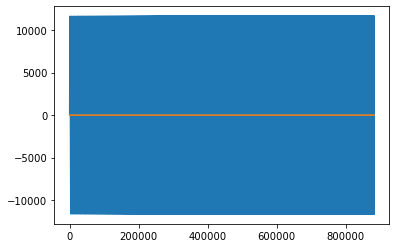

In [91]:
sample_rate, input_data = wavfile.read('./../samples/LogSweep_10_1000_44k_16-bit_L.wav')
# plt.plot(input_data[0:100])
# input_data = input_data[18 * 44000:18*44000 + 25]

upsample_scale = 8

cs = CubicSpline(np.arange(len(input_data)), input_data)

xs = np.arange(0, len(input_data), 1/upsample_scale)

# upsampled = np.int16(cs(xs))
upsampled = cs(xs)
upsampled_rate = upsample_scale * sample_rate

print("Length of recording: " + str(len(input_data)/sample_rate))
# plt.plot(xs, cs(xs))
plt.plot(input_data)
print("Length of input data: " + str(len(input_data)))
# plt.plot(xs, upsampled)
# after_biquad = biquad(input_data, 
#        a0 = 0.7368429900740087, 
#        a1 = -1.4736859801480173,
#        a2 = 0.7368429900740087,
#        b0 = 1,
#        b1 = -1.4042736459936045,
#        b2 = 0.5430983143024303
#       )

# plt.plot(after_biquad)

In [92]:
def normalize(original, output_data):
    max_original = np.amax(np.absolute(original))
    max_values = np.amax(np.absolute(output_data))
    scalar = (max_original / max_values)
    print("Scalar:", scalar)
    
    for i in range(len(output_data)):
        output_data[i] = scalar * output_data[i]

    return np.int16(output_data)

In [93]:
def biquad_with_negative_feedback(arr, a0, a1, a2, b0, b1, b2, fb_k, store_servo=True):
    servo_signal_current = 0 #
    
    servo_signal_prev1 = 0 #servo_signal sub n-1
    servo_signal_prev2 = 0 #servo_signal sub n-2
    
    y_prev1 = 0 #y prev n-1
    y_prev2 = 0 #y sub n-2
    
    output = []
    
    for i in range(len(arr)):
        # i = 0, 1, 2, 3, 4, 5...
            
        x_current = arr[i]
        
        servo_signal_current = x_current - fb_k * y_prev1
        
        if i < 44100 * 0.5 * 0.25:
#             print(x_current, y_prev1)
            pass
        
        y_current = (a0 * servo_signal_current + a1 * servo_signal_prev1 + a2 * servo_signal_prev2 - b1 * y_prev1 - b2 * y_prev2) / b0

        if store_servo:
            output.append(servo_signal_current)
        else:
            output.append(y_current)
    
        servo_signal_prev2 = servo_signal_prev1
        servo_signal_prev1 = servo_signal_current
        
        y_prev2 = y_prev1
        y_prev1 = y_current
        
    return output

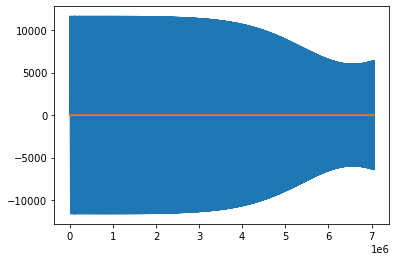

In [94]:
### 8 inch Dayton DVC ###
# after_resonance_compensation = biquad_with_negative_feedback(
# upsampled,
# a0 = 0.0057426788667661955,
# a1 = 0,
# b0 = 1,
# a2 = -0.0057426788667661955,
# b1 = -1.9884505557207934,
# b2 = 0.9885146422664675,
# fb_k = 0.9
# )

after_resonance_compensation = biquad_with_negative_feedback(
upsampled,
a0 = 0.009331629959095806,
a1 = 0,
b0 = 1,
a2 = -0.009331629959095806,
b1 = -1.9811609365263363,
b2 = 0.9813367400818084,
fb_k = 0.95
)

plt.plot(after_resonance_compensation)

[[   0    0]
 [  17    0]
 [  33    0]
 [  50    0]
 [  66    0]
 [  83    0]
 [  99    0]
 [ 116    0]
 [ 133    0]
 [ 149    0]
 [ 166    0]
 [ 182    0]
 [ 199    0]
 [ 215    0]
 [ 232    0]
 [ 248    0]
 [ 265    0]
 [ 282    0]
 [ 298    0]
 [ 315    0]
 [ 331    0]
 [ 348    0]
 [ 364    0]
 [ 381    0]
 [ 397    0]
 [ 414    0]
 [ 431    0]
 [ 447    0]
 [ 464    0]
 [ 480    0]
 [ 497    0]
 [ 513    0]
 [ 530    0]
 [ 546    0]
 [ 563    0]
 [ 580    0]
 [ 596    0]
 [ 613    0]
 [ 629    0]
 [ 646    0]
 [ 662    0]
 [ 679    0]
 [ 695    0]
 [ 712    0]
 [ 728    0]
 [ 745    0]
 [ 762    0]
 [ 778    0]
 [ 795    0]
 [ 811    0]
 [ 828    0]
 [ 844    0]
 [ 861    0]
 [ 877    0]
 [ 894    0]
 [ 910    0]
 [ 927    0]
 [ 943    0]
 [ 960    0]
 [ 976    0]
 [ 993    0]
 [1009    0]
 [1026    0]
 [1042    0]
 [1059    0]
 [1075    0]
 [1092    0]
 [1108    0]
 [1125    0]
 [1141    0]
 [1158    0]
 [1174    0]
 [1191    0]
 [1207    0]
 [1224    0]
 [1240    0]
 [1257    0]

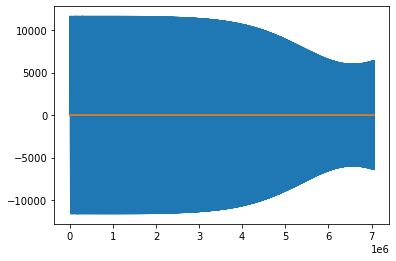

In [95]:
after_resonance_after_backwave = biquad_with_negative_feedback(
after_resonance_compensation,
a0 = 0.4116558936798249,
a1 = 0,
a2 = -0.4116558936798249,
b0 = 1,
b1 = -0.17123074520885376,
b2 = 0.17668821264035015,
fb_k = 0.9
)

def downsample(item, scale):
    cs = CubicSpline(np.arange(len(item)), item)
    xs = np.arange(0, len(item), 1/ scale)

    downsampled = cs(xs)
    downsampled = np.int16(downsampled)
    downsample_rate = int(downsample_scale * upsampled_rate)
    
    return downsampled, downsample_rate

downsample_scale = 1 / upsample_scale

downsampled, downsample_rate = downsample(after_resonance_after_backwave, 1 / upsample_scale)
downsampled_after_resonance_compensation, downsample_after_resonance_compensation_rate = downsample(after_resonance_compensation, 1 / upsample_scale)

print(input_data[:100])
print(downsampled[:100])

print(len(input_data))
print(len(downsampled))

print("Downsample Rate: "+str(downsample_rate))
print("Length of final file: " + str(len(downsampled)/downsample_rate))

wavfile.write("after_resonance_after_backwave.wav", downsample_rate, normalize(input_data, downsampled))
wavfile.write("after_resonance_compensation.wav", downsample_after_resonance_compensation_rate, normalize(input_data, downsampled_after_resonance_compensation))
wavfile.write("input_data.wav", downsample_rate, input_data)
plt.plot(after_resonance_after_backwave)

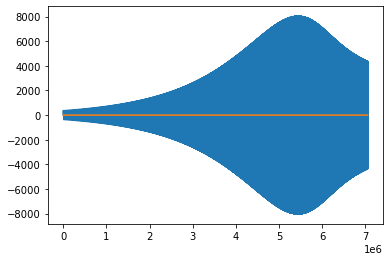

In [87]:
after_resonance_compensation_after_resonance = biquad_with_negative_feedback(
after_resonance_compensation,
a0 = 0.0057426788667661955,
a1 = 0,
b0 = 1,
a2 = -0.0057426788667661955,
b1 = -1.9884505557207934,
b2 = 0.9885146422664675,
fb_k = 0,
store_servo = False
)

plt.plot(after_resonance_compensation_after_resonance)

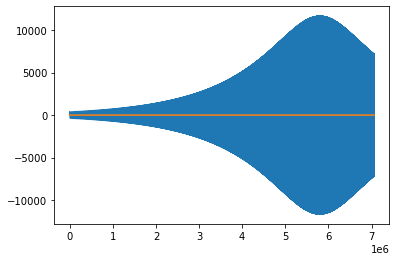

In [88]:
after_resonance_compensation_after_resonance = biquad(
upsampled,
a0 = 0.0057426788667661955,
a1 = 0,
b0 = 1,
a2 = -0.0057426788667661955,
b1 = -1.9884505557207934,
b2 = 0.9885146422664675
)

plt.plot(after_resonance_compensation_after_resonance)